In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
# plt.style.use('dark_background')
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from math import floor
from copy import deepcopy
from sklearn.metrics import confusion_matrix
import config
import models
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
import neural_networks
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
import interpret
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import viz

# prepare data

In [9]:
# currently trained only on 'clath_aux+gak_a7d2_new'
dsets = ['clath_aux+gak_new']
splits = ['test']
# feat_names = ['X_same_length_normalized'] # + data.select_final_feats(data.get_feature_names(df))

#feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
              #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
dfs, feat_names = data.load_dfs_for_lstm(dsets=dsets, splits=splits, meta=meta, normalize=False)
print('type', type(dfs))
# load model
p = 1
results = pkl.load(open('../models/dnn_full_long_normalized_across_track_1_feat.pkl', 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=p-1, arch='lstm')
dnn.model.load_state_dict(results['model_state_dict'])

# load data
# df = dfs[('clath_aux+gak_a7d2', 'train')]
df = dfs[('clath_aux+gak_new', 'test')]
X = df[feat_names[:p]]
y = df['y_consec_thresh']

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

type <class 'dict'>


# prediction plots

In [8]:
track_name = 'X_same_length_normalized'
track_name_unnormalized = 'X_same_length'
df = dfs[('clath_aux+gak_new', 'test')]
df['preds'] = dnn.predict(df[feat_names[:1]])
df = df.sort_values(by='preds')
x = df[feat_names[:1]]
y = df['y_consec_thresh'].values
preds = dnn.predict(x)
n = df.shape[0]

m = 40
xtrack_unnormalized = df[track_name_unnormalized]
xtrack = x[track_name]
xtrack_t = torch.tensor(np.array(list(xtrack.values)), dtype=torch.float)
xfeats = x[[c for c in x.columns if c != track_name]]
xfeats_t = torch.tensor(np.array(xfeats).astype(float), dtype=torch.float)


# sort things
print('acc', np.mean((preds > 0) == y))

acc 0.8246445497630331


In [46]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
        name='orange-blue', 
        colors=[(222/255, 85/255, 51/255),
                'lightgray',
                (50/255, 129/255, 168/255)]
    )
vabs = max(abs(df['preds'])) // 2
norm=matplotlib.colors.Normalize(vmin=-vabs, vmax=vabs)

# scatter plots

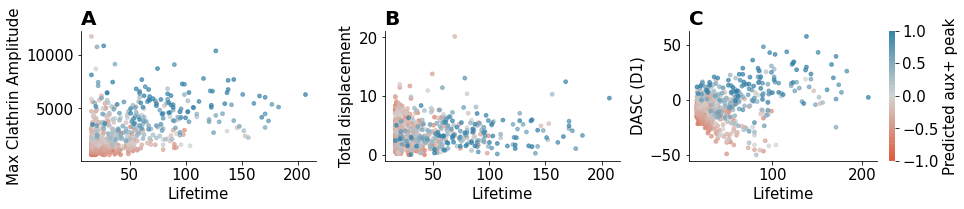

In [71]:
R, C = 1, 3
alpha = 0.7
kwargs = dict(
    cmap=cmap, norm=norm, alpha=alpha, s=14, edgecolors=None
)
plt.figure(figsize=(C * 4.5, R * 3))
plt.subplot(R, C, 1)
plt.scatter(df['lifetime'], df['X_max'], c=df['preds'], **kwargs)
plt.xlabel('Lifetime')
plt.ylabel('Max Clathrin Amplitude')
plt.title('A', loc='left', fontweight='bold')

plt.subplot(R, C, 2)
plt.scatter(df['lifetime'], df['mean_total_displacement'] * df['lifetime'], c=df['preds'], **kwargs)
plt.xlabel('Lifetime')
plt.ylabel('Total displacement')
plt.title('B', loc='left', fontweight='bold')

plt.subplot(R, C, 3)
plt.scatter(df['lifetime'], df['X_d1'] * df['lifetime'], c=df['preds'], **kwargs)
plt.xlabel('Lifetime')
plt.ylabel('DASC (D1)')
plt.title('C', loc='left', fontweight='bold')
cb = plt.colorbar(label='Predicted aux+ peak')
cb.outline.set_visible(False)
viz.savefig('top_feats_scatter')

# viz errs

In [ ]:
y = df['y_consec_thresh'].astype(bool)
p = df['preds'].values > 0

tp = y & p
tn = ~y & ~p
fp = ~y & p
fn = y & ~p
print('fracs', 'fp', fp.sum() / y.size, 'fn', fn.sum() / y.size)
for idxs, name in zip([fp, fn], ['fp', 'fn']):    
    d = df[idxs]
    errs = viz.viz_biggest_errs(d, None, None, d['y_consec_thresh'],
                            d['preds'] > 0, d['preds'], show_track_num=False,
                               text_labels= idxs is fp)
    viz.savefig(name)

# viz total acc

In [12]:
dfs, feat_names = data.load_dfs_for_lstm(dsets=dsets, splits=splits,
                                         meta=meta, normalize=False,
                                         filter_short=False)
df = dfs[('clath_aux+gak_new', 'test')]
X = df[feat_names[:p]]
y = df['y_consec_thresh']

100%|██████████| 1/1 [00:02<00:00,  2.48s/it]
